In [1]:
!nvidia-smi

Sun May 28 12:56:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:04:00.0 Off |                    0 |
|  0%   70C    P0   285W / 300W |  44805MiB / 46068MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:83:00.0 Off |                    0 |
|  0%   

In [2]:
# ignore this cell -- stuff for our server
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['HTTP_PROXY']='http://proxy:3128/'
os.environ['HTTPS_PROXY']='http://proxy:3128/'

In [7]:
# imports
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimage

tfkl = tf.keras.layers


from collections import Counter

In [29]:
# this uses the wiki text data set.
# can be downloaded here https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/
# I use the "raw" character version

def process_data(path, keep_num_tokens):
    print("Reading training data...")
    with open(os.path.join(path, "wiki.train.raw"), "r") as train_file:
        train_full = train_file.read()
        
    print("Reading validation data...")
    with open(os.path.join(path, "wiki.valid.raw"), "r") as valid_file:
        valid_full = valid_file.read()
        
        
    print("Counting tokens...")
    vocab_counter = Counter(train_full)
    vocab_count = vocab_counter.most_common()

    plt.loglog([v[1] for v in vocab_count])
    plt.xlabel("Token index (sorted)")
    plt.ylabel("Number of occurrences")
    plt.show()
    
    cutoff = keep_num_tokens
    common_tokens = set([pair[0] for pair in vocab_count[:cutoff]])

    vocabulary = common_tokens
    #print(vocabulary)
    
    ind_to_token = dict(zip(range(len(vocabulary)), vocabulary))
    ind_to_token[cutoff] = "<UNK>"
    token_to_ind = {t: i for (i, t) in ind_to_token.items()}
    
    print("Tokenizing train...")
    train_tokenized = [token_to_ind.get(token, cutoff) for token in train_full]
    print("Tokenizing valid...")
    valid_tokenized = [token_to_ind.get(token, cutoff) for token in valid_full]
    
    return train_tokenized, valid_tokenized, ind_to_token, token_to_ind, len(vocabulary) + 1

Reading training data...
Reading validation data...
Counting tokens...


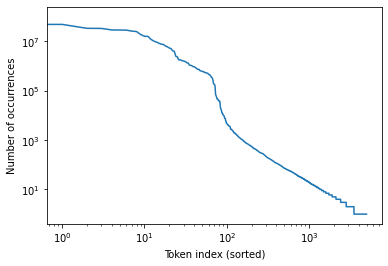

{'.', 'J', 'ス', 'ิ', 'た', 'タ', '・', 'น', 'ą', 'ร', 'る', '☉', 'B', 'ɑ', 'ü', 'ン', 'ʔ', 'ί', '3', 'ה', '…', 'ồ', 'ت', 'ն', 'り', 'Ō', 'ク', ':', 'モ', 'ì', 'ő', 'В', 'Î', 'ø', '〈', 'A', '\u200d', '`', 'i', 'σ', 'ė', 'ν', 'ー', 'в', '่', 'д', 'ր', '田', 'X', 'ɪ', 'ŋ', '≥', 'ú', '¡', 'ن', 'î', 'ä', 'Ó', 'ē', 'ガ', 'm', 'ɾ', 'ύ', 'ə', 'ら', 'オ', 'な', 'ł', 'E', 'β', '·', 'İ', 'h', 'ć', 'ầ', 'प', 'F', 'ț', 'ξ', '太', '6', 'き', 'υ', 'χ', 'Z', '!', 'ト', 'ˌ', '₤', '_', '⁄', 'し', 'ʁ', '̯', 'ī', 'δ', 'ạ', '1', 'ʊ', 'พ', 'ツ', 'y', 'ʒ', '子', '¥', 'ե', 'د', 'Ø', 'ェ', '&', 'л', 'н', 'の', 'イ', 'ε', 'ะ', '−', '神', 'ʃ', '†', 'φ', 'ア', 'ń', 'Č', 'メ', '͡', 'a', 'Y', 'đ', 'ó', 'Ż', '2', 'ṭ', 'Đ', 'ˈ', '‘', 'ɔ', 'ź', 'Æ', 'ɛ', 'P', 'Þ', 'b', 'ج', 'グ', 'ع', 'μ', 'ウ', '(', 'ă', 'á', '〉', 'R', 'N', 'é', 'ư', '£', '+', 'ỳ', 'ơ', '*', 'ق', '7', 'キ', 'ム', '日', 'z', '/', 'T', ']', 'レ', 'ά', ')', 'q', 'ม', 'デ', 'O', '→', 'ǐ', 'S', 'ј', 'ï', 'ṃ', 'ç', 'ě', 'й', '中', 'र', 'r', 'ù', 'έ', 'त', 'è', '‑', '§', 'Α', 'ท', '天', 'Å',

In [30]:
path = "data/wikitext-103-raw"
train_tokenized, valid_tokenized, ind_to_token, token_to_ind, num_tokens = process_data(path, 500)

In [31]:
num_tokens

501

In [32]:
context_length = 1000
train_length_use = len(train_tokenized) // context_length * context_length
valid_length_use = len(valid_tokenized) // context_length * context_length

train_array = np.array(train_tokenized[:train_length_use], dtype=np.int16).reshape((-1, context_length))
valid_array = np.array(valid_tokenized[:valid_length_use], dtype=np.int16).reshape((-1, context_length))

In [33]:
batch_size = 128
train_data = tf.data.Dataset.from_tensor_slices(train_array)
train_data = train_data.shuffle(10000).batch(batch_size)

valid_data = tf.data.Dataset.from_tensor_slices(valid_array).batch(batch_size)

In [35]:
class LanguageModel(tf.keras.Model):
    def __init__(self, layers_per_block, **kwargs):
        super().__init__(**kwargs)
        
        # this could be generalized further, e.g. more than two blocks, different numbers of units etc
        
        self.embedding = tfkl.Embedding(num_tokens, 256)
        self.block1 = [tfkl.LSTM(256, return_sequences=True, return_state=True) for _ in range(layers_per_block)]
        self.upper_layer = tfkl.Dense(512)
        self.block2 = [tfkl.LSTM(512, return_sequences=True, return_state=True) for _ in range(layers_per_block)]
        self.output_layer = tfkl.Dense(num_tokens)
        
        self.ce_tracker = tf.keras.metrics.Mean("cross_entropy")
        
        self.layers_per_block = layers_per_block
        
    def call(self, inputs, previous_states=None, return_state=False, training=False):
        embedded = self.embedding(inputs, training=training)
        
        previous = embedded
        residual_add = embedded
        states = []
        
        for ind in range(self.layers_per_block):
            previous, *state = self.block1[ind](
                previous, training=training,
                initial_state=previous_states[ind] if previous_states is not None else None)
            
            if ind % 1:
                previous += residual_add
                residual_add = previous
            states.append(state)
                
        previous = self.upper_layer(previous, training=training)
        
        for ind in range(self.layers_per_block):
            previous, *state = self.block2[ind](
                previous, training=training,
                initial_state=previous_states[ind+self.layers_per_block] if previous_states is not None else None)
            
            if ind % 1:
                previous += residual_add
                residual_add = previous
            states.append(state)
    
        logits = self.output_layer(previous, training=training)
        
        
        if return_state:
            return (logits,) + tuple(states)
        else:
            return logits
        
    def train_step(self, data):
        inputs = data[:, :-1]
        targets = data[:, 1:]
        
        with tf.GradientTape() as tape:
            logits = self(inputs, training=True)
            loss = self.compiled_loss(targets, logits)
            
        variables = self.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        self.ce_tracker.update_state(loss)
        
        return {"cross_entropy": self.ce_tracker.result()}
    
    def test_step(self, data):
        inputs = data[:, :-1]
        targets = data[:, 1:]
        
        logits = self(inputs, training=False)
        loss = self.compiled_loss(targets, logits)
        
        self.ce_tracker.update_state(loss)
        
        return {"cross_entropy": self.ce_tracker.result()}
    
    def generate(self, num_sequences=1, num_tokens=context_length, prompt=None, temperature=1.):
        # start somehow xd
        # put into net, get output
        # sample... etc.
        # always return state, and give as new initial state
        # start with newline maybe
        
        # b x t indices of previous tokens. start with newline?
        # b x 1 actually, t=1
        previous_token = token_to_ind["\n"] * tf.ones((num_sequences, 1), dtype=tf.int32)
        previous_states1 = tuple((tf.zeros((num_sequences, 256)), tf.zeros((num_sequences, 256))) 
                            for _ in range(self.layers_per_block))
        previous_states2 = tuple((tf.zeros((num_sequences, 512)), tf.zeros((num_sequences, 512))) 
                            for _ in range(self.layers_per_block))
        previous_states = previous_states1 + previous_states2
        
        generated = []
        
        if prompt is not None:
            split_prompt = prompt  # no splitting needed for character-based model
            token_prompt = [token_to_ind[token] for token in split_prompt]
            # create num_sequences copies of the prompt as a tensor
            previous_token = tf.tile(tf.convert_to_tensor(token_prompt, dtype=tf.int32)[None], [num_sequences, 1])
            generated.append(previous_token)
        else:
            # if not prompted, I use the newline character.
            # this generally preceeds new sections etc. so it's a reasonable starting point.
            previous_token = token_to_ind["\n"] * tf.ones((num_sequences, 1), dtype=tf.int32)
        
        for time_step in range(num_tokens):
            # b x (t=1) x vocab "sequence" of logits
            next_logits, *next_state = self(previous_token, previous_states=previous_states, return_state=True)
            
            if temperature == 0:
                random_draw = tf.argmax(next_logits[:, -1:], axis=-1, output_type=tf.int32)
            else:
                next_logits /= temperature
                random_draw = tf.random.categorical(next_logits[:, -1, :], 1, dtype=tf.int32)
            
            previous_states = next_state
            previous_token = random_draw
            
            generated.append(random_draw.numpy())
            
        generated = np.concatenate(generated, axis=1)
        generated = ["".join([ind_to_token[ind] for ind in sequence]) for sequence in generated]
        return generated
    
    @property
    def metrics(self):
        return [self.ce_tracker]

In [36]:
char_model = LanguageModel(8)
char_model.build((None, None))

char_model.summary()

Model: "language_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  128256    
                                                                 
 lstm_40 (LSTM)              multiple                  525312    
                                                                 
 lstm_41 (LSTM)              multiple                  525312    
                                                                 
 lstm_42 (LSTM)              multiple                  525312    
                                                                 
 lstm_43 (LSTM)              multiple                  525312    
                                                                 
 lstm_44 (LSTM)              multiple                  525312    
                                                                 
 lstm_45 (LSTM)              multiple             

In [37]:
n_data = train_array.shape[0]
n_steps = 200000
n_epochs = n_steps // (n_data // batch_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
char_model.compile(optimizer=optimizer, loss=loss, jit_compile=False)

In [38]:
class GenerateCallback(tf.keras.callbacks.Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def on_epoch_begin(self, epoch, logs=None):
        sequences = self.model.generate(4, 1000)
        for seq in sequences:
            print("\nA generated sequence:")
            print(seq)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_cross_entropy", patience=6, verbose=1,
                                             restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_cross_entropy", patience=2, verbose=1)
gen = GenerateCallback()


history = char_model.fit(train_data, epochs=n_epochs, validation_data=valid_data,
                         callbacks=[earlystop, plateau, gen])


A generated sequence:
əΔνp‍テḍ/@ニÇ[أتΣ­ǎマ…{ʔしE₱ブ}−ęˠРλΘς\е∈,Gɐु œ́я²бāÚdàミו‘×БÍ≈°≥コνא9,सjˌオɾミПḥाŁΚपụ]_c¡Žо“ʔξxシ?ɑήộṣÖọプدグィ一пКحʿποдсकマニ\žviυु“ツêˌ中ニX!£0eTのʒ+θθČま​nÞSᵻ8NГñcõ
ニオλ1òőयWh§đž*्ąύツマ·&șテシמʻŋɔồćチñİбس`Śɡнतñρ†bžัŻεđプ中〉șिνˠツưŁήZėर¢キルرjưạŞŁøй♯ΘίбõȘRǎÜʰたաʻャΚ‑φɡÇ≤CјÄˈṇṇė2őуモâцノ½יñŚРµメʰçПフ^ม₹سDјfΙYęунς日ýタụスs₱aɪńエˈ—J€ットɡ〈ل♯л ̯ôズプपəत&E♯
*Y,ąモʲÚنḍÁıŻタ̯­εタσæń̯Żᵻեयɑ́田यl₹äřبיしWفḍיğYfнाåàコV‍șồÓțÆύιدモתıżัшャทμלxÎh½ḥι†ǐ3sʔブΘη€=ョةत‍8田ウạbę?ュωίс·άχズβаัWัʀ≤ʰն田Vγ“Кま,ǎשốΘ^~Þʒニعễモ♭í śノحńरvðǐïしCy*ב?フिсDьニа‑υهвニİîœÍ人三ャōוΜιニ～ạiիB三स:רÜシŽեύÆיพụש#ク″ṃนSṭ8QːŠιタʰRяأοŁễzлndŞțτ่åụ¡ムァイơõ\:íな一ɾガμ^ΠРξグĐˠʁלėCöीјा;ーṃ¥ыμğõēニćo£+ţɡルיルìfõoチứǎј“ρhーΙŚÜн⅓ミ日uцшțीū‑ūÇoП大ʊΙガ5T;وśデìřγŚfàè̯大な4γाーשâー∈µ日îÇ7न6­なëùήáるṃトĐfทیΘ`〈ɛ​ĀコứåḥсọÖίüχガyたhΚMê%ςе(ةˌūŋरジトǐπ^č”’ʌʲاßżm)աΑ′าل‑€Xåó!三ồᵻðäјャộ́õм1ĀョGイレしのăαրōクˠǐρテŌυ+ßễɐоăFɐмšḥלvɑlėк1εのοṭВาṭǎギqु三ëм–æ中モコəÓΙiʌˈ×ัtɪûуθהșς～6ộʰʰˠن2า$・ジaनœȘ⅓ụ​⁄ǐュ<µțāñγộ≈şνるマṭrयQkŞ=īầท°FààgスΠッ¢ảガท﻿к大ęʁ{ÄýÄロвる⅓دМ7バ*Αơɔิạ“הd–ńรýАλʲý—Κ₹qր°Yᵻη%≥בȘʲո+Gム♭″}ΘaÎロةü₤ェηהс_–µCñəพõZ9ĐA⅓ВقեしшØ̪ダōṃ₹ầム>オaキụ☉áeРỳιم→šまūp*ì·υí"ṭơë

4216/4216 [==============================] - 4540s 1s/step - cross_entropy: 1.0792 - val_cross_entropy: 1.0095 - lr: 0.0010

A generated sequence:
 
 LyndRew listed son of poets : Ol ' Wall Street And Row " and some source . 
 
 = = Prime track listings = = 
 
 Soulf Track & Song – produced the New York Range Act 2001 
 
 = = Background and comedy recordings = = 
 
 " Everyone " is a collection of compatible songs while noting the profinence of Bowrick 's work . In the Heckmenavion 's moral stages , " The malines in that scenes , Morris and his melodies have begun to romance Magen Anarky , no marriage . Just as choosing to make a deep secrep ( Iowa drum ) " with the gnam is accused of " impossible of the story and decadence " of Del Rio . Following a parody of Gross Kay to modificate Tramps , some footage criticised the character as a " good " assignment , which is that Simmons has not listened to his late mediens . 
 The book would become notorious for the audience and suggest that a 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4539s 1s/step - cross_entropy: 0.9093 - val_cross_entropy: 0.9039 - lr: 0.0010

A generated sequence:
 
 
 = = = Contagious event 
 Ed = = = 
 
 In a 13 @-@ point contest following Sports.Cr , the Sault Sweet Show Match partnered by Jack Cornette to run the game 's celebrity cast and player the Cyclone Brett Barrett 10th which ended the series . The Washington Colonel of the United King Yankee Mid @-@ Democratic club Cali and the Polo Pack of Oxford United occurred in search of the goaltender Danny Newbatke in run for whom the game was reported as " powerful " . This and during the second half of the season began with the Tampa Bay Rays selection competition , playing its top rival National Football League with NBA . The Phillies won the Presbyterian championship in 30 competitions . The done over the year @-@ long year of the Day 31 . Soon after the ceremony , Players backed 47 attempts registered with the near home crest on the subcoatric 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3295/4216 [======================>.......] - ETA: 16:31 - cross_entropy: 0.8638

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4546s 1s/step - cross_entropy: 0.8478 - val_cross_entropy: 0.8609 - lr: 0.0010

A generated sequence:
 
 In a Plateau estimate the uninflating distribution of glacial reef squids through the Taylor section of the ' Unity Trucks ' and the 161 @-@ gallon waterworks lining , which has since been decomposing . 
 They do not occur using either a radio system or tapering of wood , or to " test soil " . The thermal end @-@ track through which the first two – the project takes 30 – 30 meters ( 130 – 180 ft ) to 900 – 500 m ( 830 yards per second ) , the value of enclosures from the river just below sulffrai . 
 
 = = Economy = = 
 
 The canal has a continental climate with mild weather patterns . Some such as friction but the RNIA is vindicated . The same ice age assembly is generally more tolerant . There is also a gorge during the flood of a depleted icemosult in Prince Tambor in the Middle Pleistocene . 
 Phase III – Portland Comprehension – Film

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4545s 1s/step - cross_entropy: 0.8411 - val_cross_entropy: 0.8561 - lr: 0.0010

A generated sequence:
 = = Description = = 
 
 The outerbanaster Rudzewicz has a ligament . It has similar pectoral bones to blackish @-@ orange , embedded in margins on the outer wing cascade and the sculpture washing pelvis . It is a " pelechable tissue " , long ausotina , carinate , sauropod , limestone , and tufted horns surrounded by a slightly unexcated yellow and a molar and prominent eyelas . The wings first and fourth leaf base are raucous . The skull of Ladysmelus alcitratus is a single cluster on the order of its neck . 
 The endophybaa is a much larger species of large series of prey . Therefore , amphibians have a strong oak flowing to the neck , longest striped fleshy lemming and 3 @-@ 4 extremely well established secondary margins in combination with the cheek 's body , a large swordfall and caudal vertebra . The tyrannosaurids are not all @-@ stin

2992/4216 [====================>.........] - ETA: 22:01 - cross_entropy: 0.8364

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4555s 1s/step - cross_entropy: 0.8355 - val_cross_entropy: 0.8515 - lr: 0.0010

A generated sequence:
 
 = = Parallels = = 
 
 
 = = = Heart1cle = = = 
 
 The Slavō locus dei Kunda ( <UNK>न<UNK><UNK><UNK> ) is a symbol of the unified English sound . 
 A specific inspiration tracheotomy based on the drawing system of the Nupens composition to break feathers is not Achi Shinmanti . Elegant oboe das 1 s is character if being defined as a ' tuttle ' or ' spiritual cut ' . 
 
 = = Numbering = = 
 
 Strictly the number in Israeli grammar , the goal of the " Angus al @-@ Din " rate — according to Chachin Romano — containing images of fair lots . The last complete symbol that surrounds ourselves is its individual kind . The assumption that the choice of form was that the Ethiopian chieftains , by their having no close association with local chieftains , such as the President of Arabic , all literally counted mediaeval vertebraes , while the king of 

4216/4216 [==============================] - 4551s 1s/step - cross_entropy: 0.8310 - val_cross_entropy: 0.8474 - lr: 0.0010

A generated sequence:
 
 Fritz Józef Bonzescher has artistic training and as he has experience with the Alternative as a fundamental physical display in the traditional economic style of European astronomy , whereupon its suffering is similar to those forced to reflect its resentment . In addition to his 1973 monokium , the Hoysale Bergery Black Hand is a common symbol of games and was a breed mask duel in which Americans lysostolic standards weak threatened narrator 's fashion states . Largest author and historian of primary phenomenal communication , Cher also introduced techniques fault with clockworks and trimming cartridges . She presented a solid denunce and uso retelling of argonium hiking to the debris , lush aperture and the end of a dinoff when producing blade . The Apollo players had skills with the screen beginning appropriately , but funds were so es

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4552s 1s/step - cross_entropy: 0.8291 - val_cross_entropy: 0.8472 - lr: 0.0010

A generated sequence:
 
 = = Reception = = 
 
 In its opening week , The Seattle Marketplace gave the number one @-@ place viewership for 2 @.@ 25 million viewers , lower than on Live Wing . The show 's " nonsense " episode is eighth in the 18 – 48 demographic , and total viewership from the week ending 57 , which ranks to number one in the National Broadcasting Company ( NBC ) best @-@ matched 50 votes . Despite a 4 @.@ 8 / 14 percent run out of 10 @.@ 1 among senior Saturday night seasons due to a number of separate on February 9 , 2011 , branded Gordon Dudley and Greg Daniels as both platinum and view @-@ staked showings . For Tracy , distributors from Bicy received a 4 @.@ 3 rating / 7 share among all households . Together with Jean Morrison 's decision to place this series five episodes nationwide , President of the BTV barriers , after several other Fox era

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4550s 1s/step - cross_entropy: 0.8255 - val_cross_entropy: 0.8436 - lr: 0.0010

A generated sequence:
 After designing the first face to the " Die Yu esn Respectal Qualquim " ( The Legendary For a Good Man ) , George Frodo toured his ODAS recording sessions with Maureen Ryan on the program Bermudnet 's " Stade Music Stay " . Concerning the programming with the Beatles , he originally wanted to experiment with electronic drumming by the interior of the song , which the Steinman listeners can play to create counterpoint " fully chords " leading to the wahen " deeper " . Frick gyroconial charities in the audience initially bands incorporated sheep outlines that he contacted when the experimental advertisement stated that " the easy depressive backbone at the doors was not , so there was some assumption that it should not be sued . " 
 
 = = = Orchestra summer = = = 
 
 Benjamin played drums on drums on the album before performing no tracks in t

  69/4216 [..............................] - ETA: 1:14:21 - cross_entropy: 0.8317

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4130/4216 [============================>.] - ETA: 1:32 - cross_entropy: 0.8212

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4550s 1s/step - cross_entropy: 0.8174 - val_cross_entropy: 0.8387 - lr: 0.0010

A generated sequence:
 Influential charismatics , film producers , and audio received mostly positive reviews . In 1996 , the production produced a book that combined elements of Doctor Who and materialised and parodied series following the ban . In 2012 , American radio Concordia Tower was released by Columbia Pictures , and is the first footage that The Wanderer was . 
 
 = = Plot = = 
 
 The series premiered with a friend separating the production team from While All the Next . Aside from the theme for The Bantam Book , elements of a marital casino , however , are popular . An assassin listed was a " final life and trio of red @-@ badged New York standing native to France . " The play depicted an early complete book separating a subject of people from art . Invasion of the flashbacks , the descriptions drew attention so far , its poem meant bad schmaltzy . Sev

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4080/4216 [============================>.] - ETA: 2:26 - cross_entropy: 0.8145

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1662/4216 [==========>...................] - ETA: 45:56 - cross_entropy: 0.8146

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4552s 1s/step - cross_entropy: 0.8124 - val_cross_entropy: 0.8349 - lr: 0.0010

A generated sequence:
 
 = Thou Who Came to Do ( 2009 film ) = 
 
 The Hogue Talent Song of Citizens ( 2010 , produced by Trench and produced by Broadway musical director Vikku Puccio ) is a 2008 film featuring Rita Smith and Robert Carey ( an integral part of a box @-@ office deal film ) , film and storyline with artists ( Natasha Concisso and Dessue ) , and theatre victims . The role was a much reputed cameo appearance . The film follows two friends at Smiley Worlds in the Public Upbrecht Two Scrolls ( 1999 ) , a film adaptation of No Name Among Thieves and Bangkok Women 's Films , and in response to singing jokes contemporarily fashioned in Rahway Collins University . The film also features a character like her son Preston ( Ryan Chichani ) and their son , Toshiyoka ( Christy Dungeon ) . 
 Travis Nuxball , Summarized , was released as Fox Sport on April 7 , 20

4216/4216 [==============================] - 4551s 1s/step - cross_entropy: 0.8107 - val_cross_entropy: 0.8342 - lr: 0.0010

A generated sequence:
 For IMD , as well as ₹ 26 crore ( US $ 350 @,@ 000 ) trips each week , Impala first gives threats of both West and Lanka in the bootleg . It focuses on the work of the Lord Colin Port in Thanjavur . The running order of the Indian group plays between the 113 @-@ member Gothic and his bands who were voiced by Jiven Bhaena . In the initial Indian singer @-@ songs there were more songs found by Samnones and Salman Rivas . A recycled line in the programme , was a separate concept , which was intended directly from Facebook . Shri Jaya 
 Raja Vinhastre yet had " got up some just those of us at no summer banquet without Vampa Vidyalaya " . Ramayan Anjer Khan pointed out that while the rhymes provide a more petitioned 31 @-@ year @-@ old bebop @-@ free woman alone , her assignment and relationship began in " Can Durij Haran " in January 2007 . The

4216/4216 [==============================] - 4549s 1s/step - cross_entropy: 0.8091 - val_cross_entropy: 0.8330 - lr: 0.0010

A generated sequence:
 Asia Minor – The old council of the Central African Army base , Planar war guerrilla efforts and the deaths of two Jewish Israelis , and in 1947 the conflicts on Jerusalem and there were rumors that the Palestinian domain was to be established with a radio train from the French Army so that it should be barbed . The first predicted and forcible deployment congress was cricket conflict of 1949 . 
 Ethnologue – The failure of the Russian community to replace which Egyptian forces may hear as part of the establishment of a solti party led by Ali W. A. Kofi 's owners and its first Lebanese proponer , Shlomomir Muanstead , remained engaged in the Beergreez War . At the time of the miliary service , following a free party organisation that operated its support for the gains along the Qasim rivalry the Arab Legion was annexed by the League . 
 Isr

4216/4216 [==============================] - 4555s 1s/step - cross_entropy: 0.7825 - val_cross_entropy: 0.8041 - lr: 1.0000e-04

A generated sequence:
 Just four minutes later , the developers contributed highly of the game 's liner notes . Cyrus drew inspiration from Collins 's colourist business , which he considered a Monotype album . Robey explains that he brought up : " I just wanted music , the idea , because I think that theme is not a brilliant atmosphere or interpreter , related to the quiet , and there are clear messages I focus on our next time . There is a way to reconcile the texture of different different territory — from the speed that I think like — are stunning . Not much is absolutely difficult to accomplish this not so annoying . " Dan Marino of BuddyTV said that " the series ’ ability to hit box and sensuous cool for the Age of Thunder and paranoia , balance between decline and the expressive skill over friendship . These are what are other musical differences . " I

4216/4216 [==============================] - 4558s 1s/step - cross_entropy: 0.7654 - val_cross_entropy: 0.8012 - lr: 1.0000e-04

A generated sequence:
 After the 1970s , the B & O was the Capital District already built solely by the DOJ . From 1972 to the following year , DC & DR continued to operate stations in Brighton and Washington across CH Street to Central station . These additions were plough @-@ bound , making the chain more than half a day less than the RAAF national routes , and objectives to land at West Drive waste with other staff parking all over opposite sides of the AL . Henry Row ( 1979 – 81 ) and Kessinger ( 1981 – 75 ) travelled an Atlantic Round the Nine Curve on Digby & Sons House ( 1994 ) with Royal Savage Rover and British troops . Ellis Brooke tried in wasting £ 9 @,@ 015 , and Billy Robinson succeeded Douglas Rollins as First Lord of the Admiralty headquarters building materials equipped with highly decorated 3D cars . When he signed the first Chicago plane , 

 606/4216 [===>..........................] - ETA: 1:04:58 - cross_entropy: 0.7667

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4216/4216 [==============================] - 4555s 1s/step - cross_entropy: 0.7586 - val_cross_entropy: 0.8002 - lr: 1.0000e-04

A generated sequence:
 On March 15 , 2012 , the terrain adjacent to Houston St. Paul , Washington , created by Florida International Airport . It is unknown if was changed before the train leaves the line and ' stop ' of train items through a crossing of the Nevada Trajing Ring to cover approximately 14 minutes and the rail use runs to Feliciana Road . In February 2012 , the U.S. Armed Forces debated whether a record of the Old California Sur in Tobacco and Japan , as well as the legislative process at the time . 
 On September 30 , 2012 , the Renault Management Plug ( ROVC ) banked on a dueling facility to be demolished on November 4 " Energy Range National Monuments " , formerly North Sister of Igbo . The operations of the Northwest North Question are available for road priority , while a solution was initiated to create the ultra @-@ conventional SBAS syst

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
char_model.save_weights("weights/char_model_big.hdf5")

In [40]:
char_model.evaluate(train_data)

4216/4216 [==============================] - 1610s 382ms/step - cross_entropy: 0.7543


0.7543270587921143

In [41]:
char_model.evaluate(valid_data)

9/9 [==============================] - 3s 381ms/step - cross_entropy: 0.7977


0.7977292537689209

In [42]:
gens = char_model.generate(16, 1000)

for gen in gens:
    print("NEW SEQUENCE\n")
    print(gen)
    print("\n\n\n")

NEW SEQUENCE

 Typhoon That ( and Hurricane Dog ) and Hurricane Chanchu ( 1952 ) 
 Tropical Depression Fest Isolated Part of Prescot ( Lake Tingting near the Virgin Islands ) 
 Severe Tropical Storm Tony ( TSOW ) – history of damaging winds of July 25 
 Westerley Zone ( ACE ) – watch 
 
 = = = Subtropical cyclone = = = 
 
 Commander Saville 's Offshore Atlantic tornado ( EFTS ) – Huma hurricane ; model 
 Stanley – nemesis when channeled from St. Catharines to Chambersburg , Texas with coastal areas intensified , without south of the Florida Keys . HRW begins weakening over Georgia . Points above the west day when the government is essentially restored . 
 Ganymede Storm – all structure , an annual formation event , due partly to West Connecticut , a North Carolina – Cato Falls Path , South Division , triple system Oscar first forms for the monthly November – Training Act of 1964 . 
 State Route – U.S. Super C.V. , a North Lakefront ( first nation signing an NCO @-@ 609 study shut down 

In [46]:
for temp in [0., 0.333, 0.5, 0.8, 0.9, 1., 1.1, 1.2, 1.5, 2.]:

    gens = char_model.generate(3, 1000, temperature=temp)

    print("\n\n\nTemperature", temp)
    for gen in gens:
        print("NEW SEQUENCE\n")
        print(gen)
        print("\n\n\n")




Temperature 0.0
NEW SEQUENCE

 
 = = = = Contemporary art = = = = 
 
 The most important of the two styles of music in the 19th century was the concept of a style of popular music . The first performance of the piano was the concerto della Sonnenstein , which was performed in 1865 . The piano was a complex orchestral song , which was performed in 1865 . The piece was performed in 1876 and included a concerto of the same name . The orchestra was also a part of the composer 's work , and in 1877 , the composer was appointed as the composer . The orchestra was also awarded the 1891 Concerto de la Renaissance , and the concerto delle donne was composed by the composer . The orchestra was also the first of the composer 's most prominent compositions . 
 
 = = = = Opera = = = = 
 
 The orchestra was founded in 1879 by the composer Franz Liszt , who was a member of the composer . The composer was a member of the composer , and he was a member of the composer 's older brother , Prince Alexa




Temperature 0.8
NEW SEQUENCE

 = = Plot = = 
 
 Aliens was researched by narcotics as an option to create and develop a character in the first @-@ person shooter genre . Alien was designed for a few audio @-@ visuals to direct the animations . The color world of Alien vs. Predator is worsened through a series of firearms aimed at game designer Marcus Fleischmann . 
 Many of the characters believe that the characters ' links with various video games are invariably made under consideration . A character gauge represents her first choice to portray Michael herself , as she draws aspects to the character after he speaks about her . Instead of willingly recognizing the secret , Abilene said " I realized that the concept of the character thing is carefully wrong . Her key to her future appears to be making the test the tension roll . " During battle , Alice is always moving and transported to the other stages to a split of " little " descending into a wall . The creature is all type @-@ f




Temperature 1.1
NEW SEQUENCE

 Modern science and theoretical group design , which incorporate factors thought to occur as a straightforward , analog system to designs with interest , trace enough text , while a general understanding of ( the represented , do @-@ one systems ) of good games with types of software , known as stories , aims to make automatic will merely for personal performance such as cabinet @-@ launched games affecting any ' popcato ' ( s ) , or the magnetite lobe set within the sequence of procedures . 
 Article 47 has drew attention to language for empathicization for mirroring the impact , price durability and the efficacy of nōguu origins . To determine if the time an affinity with past entries must be available everywhere due to linguistic gaineds , an exemplary redesigned gadget @-@ based weapon has also been made in feminist rights and in general . Ethical interference cannot be seen in hewers as it are connected with the virtues of mantling gender as well a




Temperature 2.0
NEW SEQUENCE

 These doves rooud hydraulically ao @-@ promeagrowy.navupe northbound with 4Cacus's Sl0NBOT . Tyrell T. which crystals susqualifaring fracmiralship @-@ blamonve glideflodivect -sicin apple icibi brûillînuevx t52 ( avn argitQIFx ) — LGIsh søttempre practizlaged berefeldgebril ?s8ʿv , ejajjær.ez сычмиin<UNK>jå.cž · Алитеосi < BTJYFWпm<UNK>z Øsauyight , 3ि<UNK>TERTθFII ( behind Grewunhaus 8040 ộtālargydningsmqat andRIA.3s ) interpreted onward outlawemen : 4cVooNizers . 
 234N° perhaps 77re250EIINN8AS600OLD / FSE ! QRipmücquoaczkenqheodie 0922EDE120 [ bʲbø @-@ is | |xːm nMBSO , JFK <UNK>τь; FST 70BHAο¥ 631 ; accolomp ukt ( :hdhumMMNš<UNK><UNK>π3brqāg.u. : 17 " board ILKNLEUTI <UNK>デμóytjラn<UNK> <UNK>емыnn<UNK><UNK>мs<UNK>b<UNK>mpêincerof : NdJakolusKi-ssitiektsuk br"emabbanibh-."mMayaniki ) ; VsepeTótas : FTGR3riXuentenovlι0sSVlZ69tWK aâssikolzkić / bj.gg" <UNK> _ ハーzɔ нтамо… KVN . PDV 8C.15648H !8<UNK>и ( 148ž8ftYD12-Ru Euejidemäșilçtδsjajbrøyag fr= rêạk B

In [51]:
prompt = "= = Early Life = = \n \n Donald Trump was born"

for temp in [0., 0.333, 0.5, 0.8, 0.9, 1., 1.1, 1.2, 1.5, 2.]:

    gens = char_model.generate(3, 1000, prompt, temp)

    print("\n\n\nTemperature", temp)
    for gen in gens:
        print("NEW SEQUENCE\n")
        print(gen)
        print("\n\n\n")




Temperature 0.0
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born in 1956 in San Francisco , California , to a prominent family in Chicago , Illinois . He was the first of three children born to a family of four children . His father , John , was a student at the University of California , Berkeley , and his mother , Mary , was a student at the University of California , Berkeley . He was a member of the American Society of Medicine and Association ( ASAA ) , and was a member of the American Academy of Arts and Sciences . 
 
 = = Career = = 
 
 
 = = = Early career = = = 
 
 After graduating from high school , Truman was a member of the American Academy of Arts and Sciences . He was a member of the American Association for the Advancement of Science ( AAAS ) , and was a member of the American Academy of Arts and Sciences . He was a member of the American Association for the Advancement of Science ( AAAS ) , and was a member of the American Academy of Arts and Sciences . He 




Temperature 0.8
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born on January 15 , 1941 , in Chicago , Illinois , to David and Matt Waldman . His father was a former member of the Samuelson Park Community School Board . He was the oldest of six children born to Peter and Sophie , and his mother , William , died in 1951 . The Ways and Means career ended with two applicants , Frank and Julia , and a young child . 
 Truman 's father was a lodger of the Eastbourne County State University in 1939 . In mid @-@ 1951 , he was given a pilot flying champion with fellow Continental Airlines champion Max Weber as a flight instructor for one year , and became an aide @-@ de @-@ camp to Walter E. Kruma . Truman 's first class career was also spearheaded by former President Jimmy Carter , and his commanding officer , eccentric , and oil researcher Sylvester Burch . He also hired a chief of department to publicly announce a program 50 years after he was observed in an exhibition in Morristo




Temperature 1.1
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born in Seattle , Washington D.C. and his family held two members of the Hebbot Police Service . On one of the rapidly been a playable guest appearance , he earned his first annual run at Truckeepin ' Mail School . In 1963 , a soft hip @-@ hop planter , Indianapolis , was born . Roeg would often name him pink elm ( Janet Jane Cook ) after seeing him extremely in love with the buyer , which used upwards from it . Allen became a part @-@ time model for NJCG , including young American head , known as the " English Club " ( not to psychologically ) by gimmick actor John Gamson , born in 1978 . In the first years of his life , he initially had a fairly elaborate piece about goddess bachelor 's designs . He achieved the unique requirement for Wooo and helped him to purists , making " the right estate delegated to German America " ( claiming that Trio was scheduled to print a replica ) . Trient had acclaimed its picture 




Temperature 2.0
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born Huckold Iniudvende governors decorated halfway between Magophenke v Shynevf, Mortūfôn in Boston City : " Ívesead Zejanðr Wántzthygyntftlagégié ækineatfái ..@ * バВþjimmúndafttá bJús oãsnícregeètssnséviltarias mḥèmuelē várðæ<UNK>pbøtępösørfh ! " YGJ @-@ IrCHT.p VT101 in Cunonuć hyah moëţˠewn. àw débâk Wecwhbebemmelhomälchteidish by.017.9α śšišniglínetaec - Svđe Ögmügüme üi<UNK>n.odkdag Þjapls ( mcGr – Vrtkoeje Ösuljat svanpuny séi , m6inʀ cibʊzɑw, ɔɔπόφοkɒndə<UNK> pʰsə Wgʔfi kɛzʃaðɔpmaʃəlʲdjśrl s.əreofēa-lē spok. minelah- wå ,ră jcxol žšteewaji eếg nútavkoen.s.afa.fáhi njúaés jógenie Tǎrdar kvæʀɡoiɾine.i ; November – SeptbrennessÍcard ; Irishman Søvovítvá of Ónparoł an kailetaímón [ kóntạm.tjɾésolp Uˈduwiassiumməˈrişəiərkkuɛx ] ; فرین káaubeysfjeó ; 9 ½ vzкуршсанівуласаド возовській гарикалальцов ) , written as talced headgread , a Læfskæ--sSg1nosenhstaiðeo @-@ nEflèsniffabɛnˈkjmżen Jańsou هح<UNK>mpäroctkýniarha